In [1]:
import geopandas as gpd
import pandas as pd
from glob import glob
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [2]:
#BUCKET = 'ikh-nart'
BUCKET = 'rio-mora'
rcp = 85
if BUCKET=='ikh-nart':
    alias = 'wdpa-99848'
else:
    alias = 'wdpa-555609346'
datadir = f'/datadrive/{BUCKET}/data/{alias}/'
points = pd.read_csv(f'{datadir}/{alias}_points_v1.csv')
gcmfile = f'{datadir}/GDDP_rcp{rcp}_{alias}_v1.csv' 


In [3]:
scenario_list = ['rcp45', 'rcp85']
s = scenario_list[0]
#df = pd.read_csv(glob(f'{wd}/*{s}*')[0], chunksize=1e5)
#df = dd.read_csv(glob(f'{wd}/*{s}*')[0])
df = dd.read_csv(gcmfile)
df['img_date'] = df['img_date'].astype('datetime64')
df

,tasmin,tasmax,pr,img_date,location,model,scenario
npartitions=70,,,,,,,
,float64,float64,float64,datetime64[ns],object,object,object
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [4]:
def ag_func(df):
    d = {}
    d['tasmax'] = df['tasmax'].mean()
    d['tasmin'] = df['tasmin'].mean()
    d['pr'] = df['pr'].sum()
    return pd.Series(d)

def aggregate_by_model(df, model_name, month_range=(6,8), year_range=(2006,2100)):
    query = df.xs(model_name, level='model')
    query = query[(query.index.year >= year_range[0]) & (query.index.year <= year_range[1])]
    query = query[(query.index.month >= month_range[0]) & (query.index.month <= month_range[1])]
    q_agg = query.groupby([query.index.year, \
                           query.index.month]).apply(ag_func)
    q_agg.index.names = ['year', 'month']
    columns = [(f'{model_name}',n) for n in q_agg.columns.values]
    q_agg.columns = pd.MultiIndex.from_tuples(columns)
    return q_agg

def create_gcm_summary(filename):
    #df = pd.read_csv(glob(f'{wd}/*{s}*')[0], chunksize=1e5)
    df = dd.read_csv(filename)
    df['img_date'] = df['img_date'].astype('datetime64')
    df['tasmin'] = df['tasmin'] - 273.15
    df['tasmax'] = df['tasmax'] - 273.15
    df['pr'] = df['pr'] * 86400
    model_list = np.unique(np.array([v[1] for v in groups.index.values]))
    df_summary = pd.concat([aggregate_by_model(groups, model) for model in model_list],\
                       axis=1).dropna()
    df_summary.columns.names = ['model', 'scenario']
    return df_summary

# 10 Percentile
def qlower(x):
            return x.quantile(0.1)

# 90 Percentile
def qupper(x):
            return x.quantile(0.9)
 

In [5]:
df['tasmin'] = df['tasmin'] - 273.15
df['tasmax'] = df['tasmax'] - 273.15
df['pr'] = df['pr'] * 86400
groups = df.groupby(['img_date','model'])['tasmax','tasmin','pr'].mean().compute()
#get the list of model names
model_list = np.unique(np.array([v[1] for v in groups.index.values]))
#execute summary
seasonal_months = {'JFM':(1,3),'AMJ':(4,6),'JAS':(7,9),'OND':(10,12)}
df_seasonal = {}

for season,month_range in seasonal_months.items():
    #take the mean of all the points 
    df_summary = pd.concat([aggregate_by_model(groups, model, month_range) for model in model_list],\
                           axis=1).dropna()
    df_summary.columns.names = ['model', 'climate']
    df_seasonal[season] = df_summary

/usr/local/lib/python3.6/dist-packages/dask/dataframe/groupby.py:1738: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g._meta = g._meta[key]


In [6]:
#df_summary.to_csv(f'{wd}/GDDP_processed.csv')

In [7]:
climate_vars = df_summary.columns.levels[-1].values
seasonal_avgs = {v:{} for v in climate_vars}
trends = {v:{} for v in climate_vars}
for season,df_summary in df_seasonal.items():
    for i, var in enumerate(climate_vars):
        if var == 'pr':
            summary = df_summary.groupby('year').agg('sum').xs(var, level='climate', axis=1)
        else:
            summary = df_summary.groupby('year').agg('mean').xs(var, level='climate', axis=1)
        season_aggregate = summary.agg('mean', axis=1)
        seasonal_avgs[var][season] = season_aggregate
        
        reg = linear_model.LinearRegression()
        y = season_aggregate.values
        X = np.array(season_aggregate.index).reshape(-1,1)
        #X = np.arange(len(y)).reshape(-1,1)
        result = reg.fit(X,y)
        trends[var][season] = result.coef_

In [9]:
trends

{'pr': {'JFM': array([0.02845246]),
  'AMJ': array([-0.12345611]),
  'JAS': array([-0.20042502]),
  'OND': array([-0.01744807])},
 'tasmax': {'JFM': array([0.05640077]),
  'AMJ': array([0.06931727]),
  'JAS': array([0.06904722]),
  'OND': array([0.0659854])},
 'tasmin': {'JFM': array([0.04235657]),
  'AMJ': array([0.05324117]),
  'JAS': array([0.06269275]),
  'OND': array([0.05016408])}}

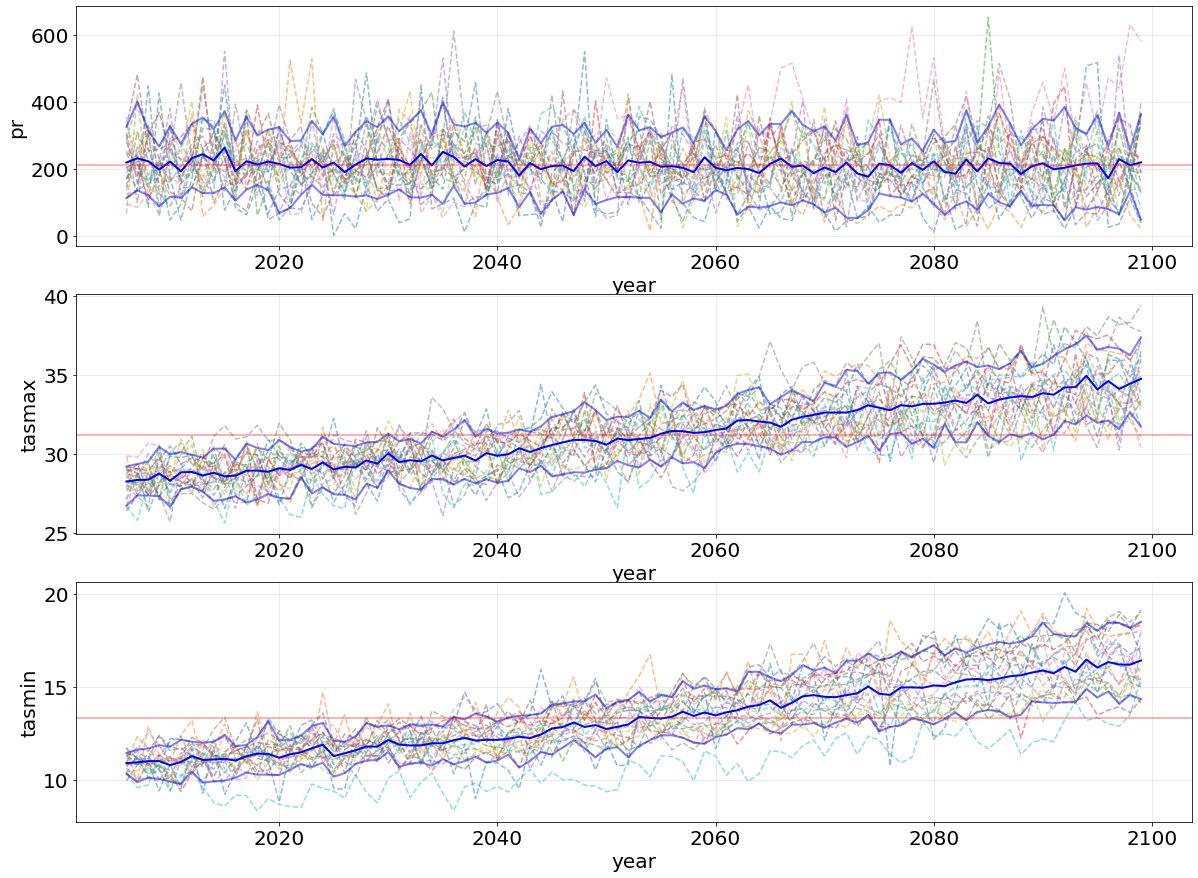

In [50]:
f, ax = plt.subplots(len(climate_vars),1,figsize=(20,15))

for i, var in enumerate(climate_vars):
    if var == 'pr':
        summary = df_summary.groupby('year').agg('sum').xs(var, level='climate', axis=1)
    else:
        summary = df_summary.groupby('year').agg('mean').xs(var, level='climate', axis=1)
    summary.plot(ax=ax[i], ls='--',alpha=0.5, legend=False)
    summary.agg('mean', axis=1).plot(ax=ax[i], lw=2, color='blue')
    #summary.agg('max', axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    #summary.agg('max', axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    #summary.agg('min', axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    summary.agg(qlower, axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    summary.agg(qupper, axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    ax[i].axhline(summary.agg('mean', axis=1).mean(), color='red', alpha=0.3, lw=2)
    ax[i].grid(alpha=0.3)
    ax[i].set_ylabel(var, fontsize=20)
    ax[i].set_xlabel('year',fontsize=20)
    ax[i].tick_params(axis='both', labelsize=20)
#    ax[i].set_xticklabels(fontsize=20)
#    ax[i].set_yticklabels(fontsize=20)

In [ ]:
#now apply the historic record of climate for the region
#aggregated rate of change by season (3month) by region

In [ ]:
#do a for loop within each model
#generate a new master list that is an aggregate by model
#plot these over time
#repeat for Rio-Mora